### Prepare list of sample files ###

Parse CSV files and fill filenames and measurements arrays.

Source directories:
- ccw - Two laps in counter-clockwise direction.
- cw - Two laps in clockwise direction.
- recovery-minus - car driving counter-clockwise was intentionally pushed out of the road and then returned back. Only measures with the negative steering angle should be recorded.
- recovery-plus - car driving clockwise was intentionally pushed out of the road and then returned back. Only measures with the positive steering angle should be recorded.
- curves - the car was trained to smoothly pass the curves.


In [1]:
import csv
import cv2
import numpy as np

samples = np.empty([0])

class Sample():
    def __init__(self, image_path, angle, flip):
        self.image_path = image_path
        self.angle = angle
        self.flip = flip
        
def extractFileName(path):
    path = path.replace('\\', '/')
    return path.split('/')[-1]
    

def importCsv(path, negativeOnly = None, positiveOnly = None, curvesOnly = None):
    result = []
    lines = []
    with open('./data/' + path + '/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            if (len(line) > 1):
                lines.append(line)
                
    print(path, len(lines), 'records')        
    
    for line in lines:
        centerImage = './data/' + path + '/IMG/' + extractFileName(line[0])
        leftImage = './data/' + path + '/IMG/' + extractFileName(line[1])
        rightImage = './data/' + path + '/IMG/' + extractFileName(line[2])
        measurement = float(line[3])
        
        if abs(measurement) > 0.9:
            continue
        
        if negativeOnly is not None and measurement >= 0:
            continue
        
        if positiveOnly is not None and measurement <= 0:
            continue
            
        if curvesOnly is not None and abs(measurement) < 0.01:
            continue
        
        camera_correction = 0.25
        
        result.append(Sample(centerImage, measurement, False))
        result.append(Sample(leftImage, measurement + camera_correction, False))
        result.append(Sample(rightImage, measurement - camera_correction, False))
        
        result.append(Sample(centerImage, measurement, True))
        result.append(Sample(leftImage,  measurement + camera_correction, True))
        result.append(Sample(rightImage, measurement - camera_correction, True))
    
    return result
        

# Drive in the middle of the road
samples = np.append(samples, importCsv('ccw'))
samples = np.append(samples, importCsv('cw'))

# Curves
samples = np.append(samples, importCsv('curves-ccw', curvesOnly = True ))
samples = np.append(samples, importCsv('curves-2', curvesOnly = True))
samples = np.append(samples, importCsv('curves-3', curvesOnly = True))
samples = np.append(samples, importCsv('curves-4'))
samples = np.append(samples, importCsv('curves-5'))
samples = np.append(samples, importCsv('curves-6'))

# Recovery
samples = np.append(samples, importCsv('recovery-minus', negativeOnly = True))
samples = np.append(samples, importCsv('recovery-minus-2', negativeOnly = True))
samples = np.append(samples, importCsv('bridge-2-minus', negativeOnly = True))
samples = np.append(samples, importCsv('recovery-plus', positiveOnly = True))
samples = np.append(samples, importCsv('recovery-plus-2', positiveOnly = True))
samples = np.append(samples, importCsv('bridge-3-plus', positiveOnly = True))
np.random.shuffle(samples)

print('Total samples: ', len(samples))


ccw 3639 records
cw 3490 records
curves-ccw 1544 records
curves-2 536 records
curves-3 1907 records
curves-4 1131 records
curves-5 435 records
curves-6 710 records
recovery-minus 3619 records
recovery-minus-2 780 records
bridge-2-minus 668 records
recovery-plus 3010 records
recovery-plus-2 225 records
bridge-3-plus 277 records
Total samples:  94632


### Choose the best color space ###

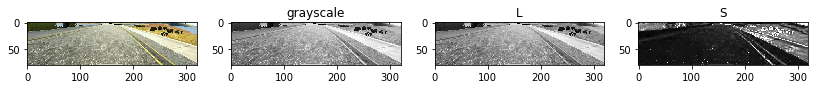

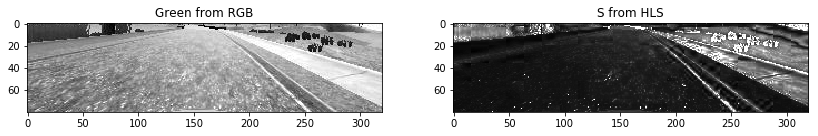

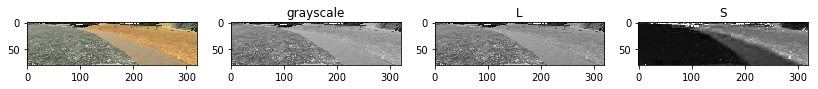

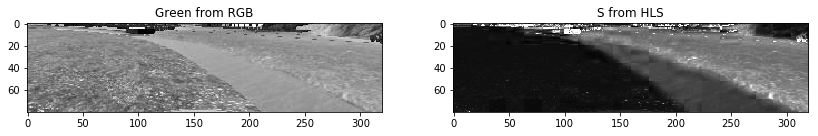

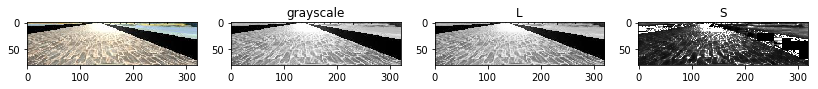

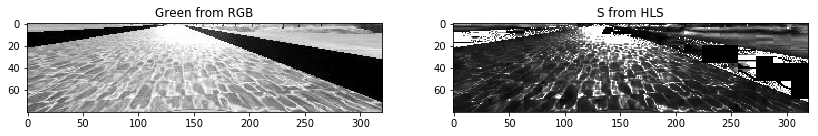

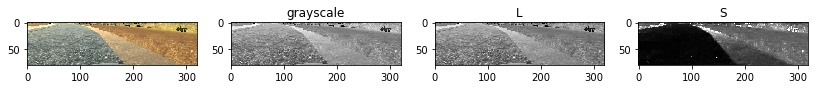

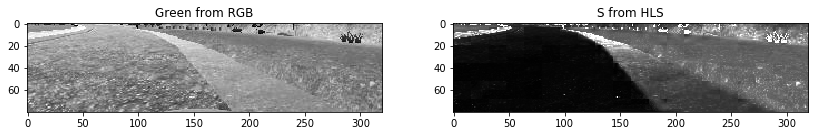

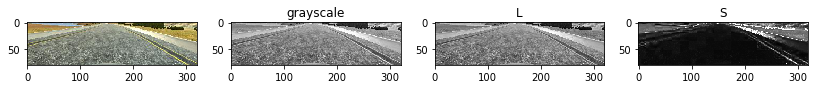

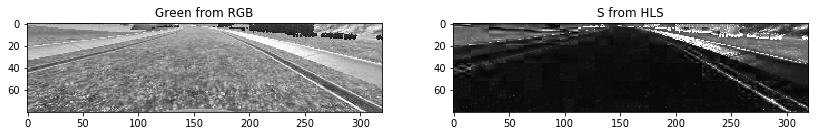

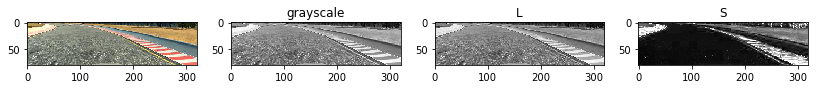

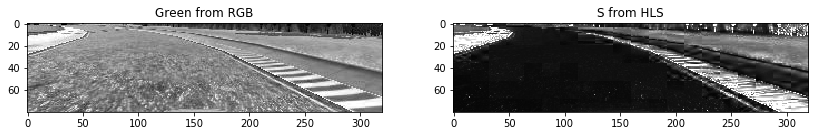

In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
plt.rcParams["figure.figsize"] = [14, 2]

def preprocess(sample):
    image = cv2.imread(sample.image_path)
    angle = sample.angle

    if (sample.flip):
        image = cv2.flip(image, 1)
        angle = -angle
     
    # Crop
    image = image[60:140]
    return image, angle

def preprocess_color(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    gray = image[:,:,1]
    return np.dstack((gray, hls[:,:,2]))

def preview(path):
    sample = Sample(path, 0, False)
    image, angle = preprocess(sample)
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    f, axarr = plt.subplots(1,4)
    l = hls[:,:,1]
    s = hls[:,:,2]
    axarr[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axarr[1].imshow(gray, cmap='gray')
    axarr[1].set_title('grayscale')
    axarr[2].imshow(l, cmap='gray')
    axarr[2].set_title('L')
    axarr[3].imshow(s, cmap='gray')
    axarr[3].set_title('S')
    plt.show()
    
    channels = preprocess_color(image);
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(channels[:,:,0], cmap='gray')
    axarr[0].set_title('Green from RGB')
    axarr[1].imshow(channels[:,:,1], cmap='gray')
    axarr[1].set_title('S from HLS')
    plt.show()
    
preview('./data/sun/IMG/center_2017_11_05_12_57_05_157.jpg')
preview('./data/sand/IMG/center_2017_11_05_12_58_53_956.jpg')
preview('./data/bridge/IMG/center_2017_11_05_12_15_59_820.jpg')
preview('./data/no-line/IMG/center_2017_11_05_12_12_21_901.jpg')
preview('./data/normal-line/IMG/center_2017_11_05_12_14_15_480.jpg')
preview('./data/red-border/IMG/center_2017_11_05_12_11_08_968.jpg')


I decided to convert 2 RGB channels into 2 channels:
1. Green channel of RGB color space that is good for detection of yellow/red lines and bridge sides. First I tried to take the gray channel, but green produces more contrast on white/red stripes.
2. S channel of HLS color space. It is good for detection of road/sand border but completelly fails on bridge bars.

These two channels combined provide clear road border in all combination of ground and lighting conditions.

### Data generators ###

In [3]:
import cv2
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

train_samples, valid_samples = train_test_split(samples, test_size=0.2)

ch, row, col = 2, 80, 320  # Trimmed image format

print('Train samples: ', len(train_samples))
print('Validation samples: ', len(valid_samples))

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        np.random.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for sample in batch_samples:
                image, angle = preprocess(sample)
                image = preprocess_color(image)
                images.append(image)
                angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(valid_samples, batch_size=32)

Train samples:  75705
Validation samples:  18927


### Test generator ###

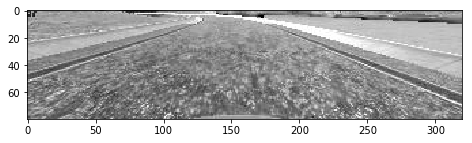

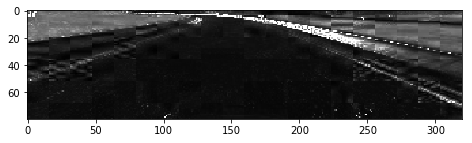

Steering angle:  -3.169015


In [4]:
test = next(train_generator)

plt.imshow(test[0][0][:,:,0], cmap='gray')
plt.show()
plt.imshow(test[0][0][:,:,1], cmap='gray')
plt.show()

print("Steering angle: ", test[1][0] * 25)


### Create the Network###

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU

alpha = 0.05

model = Sequential()

model.add(Lambda(lambda x: x/127.5 - 1.0,
        input_shape=(row, col, ch),
        output_shape=(row, col, ch), name='input'))

model.add(Conv2D(24, 5, 5, name='conv_1_5x5', subsample=(2,3)))
model.add(BatchNormalization(name='norm_1'))
model.add(LeakyReLU(alpha=alpha, name='act_1'))

model.add(Conv2D(36, 5, 5, name='conv_2_5x5', subsample=(2,2)))
model.add(BatchNormalization(name='norm_2'))
model.add(LeakyReLU(alpha=alpha, name='act_2'))

model.add(Conv2D(48, 5, 5, border_mode='valid', name='conv3_5x5', subsample=(2,2)))
model.add(BatchNormalization(name='norm_3'))
model.add(LeakyReLU(alpha=alpha, name='act_3'))

model.add(Conv2D(64, 3, 3, border_mode='valid', name='conv_4_3x3', subsample=(2,1)))
model.add(BatchNormalization(name='norm_4'))
model.add(LeakyReLU(alpha=alpha, name='act_4'))

model.add(Conv2D(64, 3, 3, border_mode='valid', name='conv_5_3x3'))
model.add(BatchNormalization(name='norm_5'))
model.add(LeakyReLU(alpha=alpha, name='act_5'))

model.add(Flatten(name='flat'))
model.add(Dropout(0.5, name='drop_1'))
model.add(Dense(128, activation='elu', name='fc_1'))
model.add(Dropout(0.5, name='drop_2'))
model.add(Dense(64, activation='elu', name='fc_2'))
model.add(Dense(16, activation='elu', name='fc_3'))
model.add(Dense(1, name='regression'))
model.add(Activation(activation='tanh', name='result'))

print(model.summary())


Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (Lambda)                   (None, 80, 320, 2)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
conv_1_5x5 (Convolution2D)       (None, 38, 106, 24)   1224        input[0][0]                      
____________________________________________________________________________________________________
norm_1 (BatchNormalization)      (None, 38, 106, 24)   96          conv_1_5x5[0][0]                 
____________________________________________________________________________________________________
act_1 (LeakyReLU)                (None, 38, 106, 24)   0           norm_1[0][0]                     
___________________________________________________________________________________________

In [6]:
from keras import optimizers
from keras.callbacks import ModelCheckpoint

NUM_EPOCHS = 15

optimizer = optimizers.Adam(lr=0.0005)


checkpoint = ModelCheckpoint('best-model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]

model.compile(loss='mse', optimizer=optimizer)

history_object = model.fit_generator(
    train_generator, 
    samples_per_epoch = len(train_samples), 
    validation_data = validation_generator, 
    nb_val_samples = len(valid_samples), 
    nb_epoch=NUM_EPOCHS,
    verbose = 1,
    callbacks=callbacks_list
)

model.save('model.h5')
print('model saved')


Epoch 1/15
75705/75705 [==============================] - 183s - loss: 0.0502 - val_loss: 0.0282
Epoch 2/15
75705/75705 [==============================] - 181s - loss: 0.0285 - val_loss: 0.0273
Epoch 3/15
75705/75705 [==============================] - 181s - loss: 0.0189 - val_loss: 0.0127
Epoch 4/15
75705/75705 [==============================] - 182s - loss: 0.0135 - val_loss: 0.0117
Epoch 5/15
75705/75705 [==============================] - 181s - loss: 0.0119 - val_loss: 0.0106
Epoch 6/15
75705/75705 [==============================] - 182s - loss: 0.0106 - val_loss: 0.0112
Epoch 7/15
75705/75705 [==============================] - 181s - loss: 0.0080 - val_loss: 0.0070
Epoch 8/15
75705/75705 [==============================] - 182s - loss: 0.0065 - val_loss: 0.0059
Epoch 9/15
75705/75705 [==============================] - 181s - loss: 0.0058 - val_loss: 0.0048
Epoch 10/15
75705/75705 [==============================] - 181s - loss: 0.0054 - val_loss: 0.0055
Epoch 11/15
75705/75705 [====

### Visualise loss ###

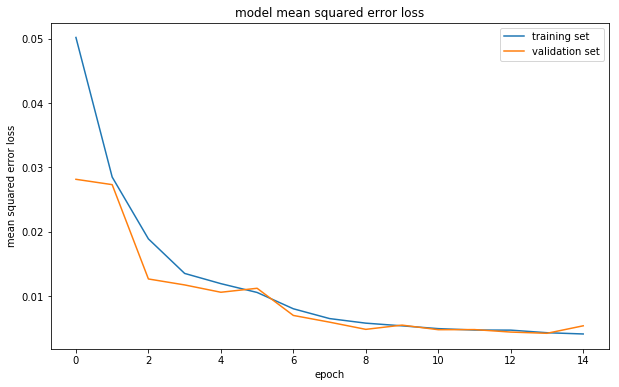

In [7]:
plt.rcParams["figure.figsize"] = [10, 6]

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### Recorded video ###

In [1]:
from IPython.display import HTML

HTML("""<video width="320" height="240" controls>
  <source src="./video.mp4">
</video>""")